In [2]:
import glob
import os 

# from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# General Utils

In [3]:
PATH = r"E:\Files\CodeProjects\MATSim\Scenarios\runner-tests"
DRT = "DRT"


COL_TO_COLOR = {
    "4 pax": "dodgerblue", 
    "3 pax": "lime", 
    "2 pax": "red", 
    "1 pax": "yellow", 
    "0 pax": "magenta", 
    "pickup": "magenta", 
    "rebalance": "darkorange", 
    "stay": "darkgray", 
    "off-service": "olive"
}

def fmt_timedelta(x):
    ts = x.total_seconds()
    hours, remainder = divmod(ts, 3600)
    minutes, _ = divmod(remainder, 60)
    return ('{:02d}:{:02d}').format(int(hours), int(minutes)) 

def iterate_algorithms(run_id, func):
    """ Run the guven func for all algorithms output in run_id"""
    print(f"output for RUN_ID: {run_id}, from func: {func.__name__}")
    r = {}
    for p in glob.glob(os.path.join(PATH, str(run_id), "*")):
        if not os.path.isdir(p):
            continue
        r[os.path.basename(p)] = func(p)
    return r

def get_last_iteration_path(alg_path):
    """ Returns the path of the last iteration output """
    assert DRT in alg_path
    path = os.path.join(alg_path, "output", "ITERS", "*")
    return max(glob.glob(path), key=lambda x: int(os.path.basename(x).split(".")[-1]))

def get_last_iter_file(alg_path, file_name):
    """ Returns the path to the last iteration version of a given file name """
    iter_path = get_last_iteration_path(alg_path)
    data_file = filter(lambda file: file.endswith(file_name), glob.glob(os.path.join(iter_path, "*")))
    return next(data_file)

def _get_column_names(dirpath):
    """ Read the description.csv file and parse the column names """
    desc = os.path.join(dirpath, "description.csv")
    if os.path.exists(desc):
        with open(desc) as desc_file:
            data = desc_file.readline()
            data = data.replace("\"", "").replace("\n", "")
            cols = data.split(", ")
    else:
        cols = None
    return cols

def read_amod_csv(fname, default_columns=None):
    """ read amod csv file, add columns according to description.csv if exists """
    if os.path.isdir(fname):
        dirname = fname
        fname = os.path.join(fname, os.path.basename(fname)) + ".csv"
    else:
        dirname = os.path.dirname(fname)
    
    cols = _get_column_names(dirname)
    return pd.read_csv(fname, names=cols)

# Ocuupancy utils

In [ ]:
def get_drt_occupancy_stats(alg_path):
    """ reads the DRT occupancy data and replace the time column with timedelta"""
    fname = "drt_occupancy_time_profiles_av.txt"
    full_path = get_last_iter_file(alg_path, fname)
    df = pd.read_table(full_path)
    df["time"] = pd.to_timedelta(df.index * 5, unit='minutes')
    return df

def get_amod_occupancy_stats(alg_path):
    """ reads amod occupancy stats add column names and a time columns"""
    full_path = os.path.join(alg_path, "output","data","statusDistributionNumPassengers")
    columns = ['4 pax', '3 pax', '2 pax', '1 pax', '0 pax', 'rebalance', 'stay', 'off-service']
    df = read_amod_csv(full_path)
    col_num = len(df.columns)
    # choose column names according to the number of columns in the data
    df.columns = columns = columns[-col_num:]
    df["time"] = pd.to_timedelta(df.index * 10, unit='seconds')
    return df

In [39]:
def _percent_in_window(df, start_time, end_time, time_column="time"):
    """ returns the percent of each column in the window """
    times = ((df[time_column] >= pd.to_timedelta(start_time)) 
             & (df[time_column] <= pd.to_timedelta(end_time)))
    means = df[times].mean(axis=0, numeric_only=True)
    return means / means.sum()

def get_ocucpancy_aggregation(alg_path):
    """ reads the occupanct info and return a stacked graph of the data"""
    alg = os.path.basename(alg_path)
    if DRT in alg_path:
        df = get_drt_occupancy_stats(alg_path)
    else:
        df = get_amod_occupancy_stats(alg_path)
    
    morning_means = _percent_in_window(df, "6hr", "9hr")
    evening_means = _percent_in_window(df, "15hr", "18hr")
    return pd.concat([morning_means, evening_means], keys=["morning", "evening"])

pd.DataFrame(iterate_algorithms(9, get_ocucpancy_aggregation)).stack().unstack(level=-2).fillna(0)

output for RUN_ID: 9, from func: get_ocucpancy_aggregation


0 pax     1 pax     2 pax     3 pax  \
evening DRT                         0.040024  0.171530  0.113053  0.033034   
        DynamicRideSharingStrategy  0.072202  0.362090  0.023202  0.000000   
        ExtDemandSupplyBeamSharing  0.070409  0.380198  0.009944  0.000000   
        HighCapacityDispatcher      0.088437  0.375364  0.016640  0.000000   
        TShareDispatcher            0.072115  0.394577  0.000000  0.000000   
morning DRT                         0.093424  0.186578  0.158725  0.047869   
        DynamicRideSharingStrategy  0.121647  0.472398  0.038425  0.001087   
        ExtDemandSupplyBeamSharing  0.124439  0.497202  0.018259  0.000740   
        HighCapacityDispatcher      0.142287  0.482296  0.036800  0.000734   
        TShareDispatcher            0.122173  0.536164  0.000000  0.000000   

                                       4 pax  off-service  rebalance      stay  
evening DRT                         0.003356          0.0   0.000000  0.639003  
        DynamicRideSharingStrategy  0.000000          0.0   0.132805  0.409702  
        ExtDemandSupplyBeamSharing  0.000000          0.0   0.000000  0.539448  
        HighCapacityDispatcher      0.000000          0.0   0.020288  0.499272  
        TShareDispatcher            0.000000          0.0   0.000000  0.533308  
morning DRT                         0.005995          0.0   0.000000  0.507408  
        DynamicRideSharingStrategy  0.000000          0.0   0.115512  0.250931  
        ExtDemandSupplyBeamSharing  0.000000          0.0   0.000000  0.359361  
        HighCapacityDispatcher      0.000000          0.0   0.051012  0.286870  
        TShareDispatcher            0.000000          0.0   0.000000  0.341663

output for RUN_ID: 12, from func: get_occupancy_graphs


<Figure size 432x288 with 0 Axes>

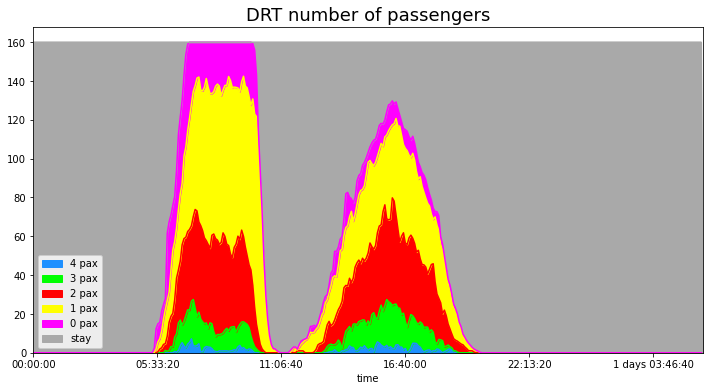

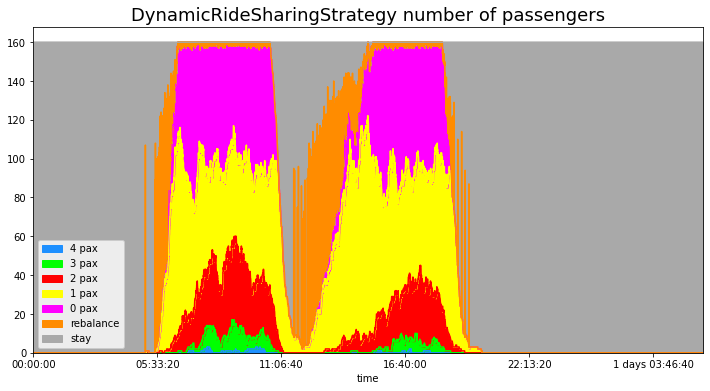

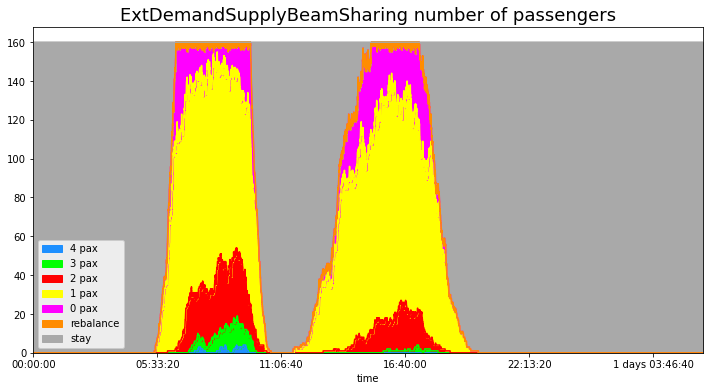

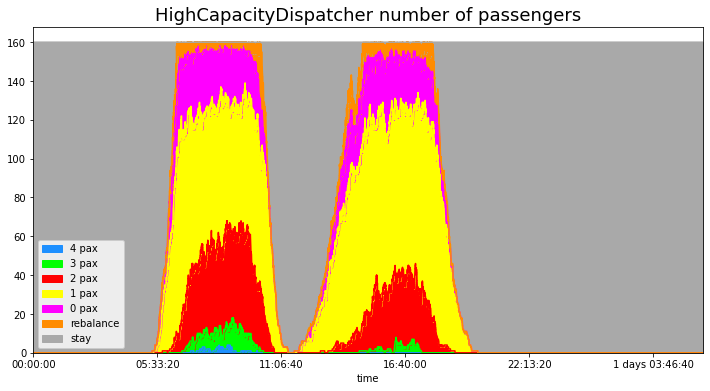

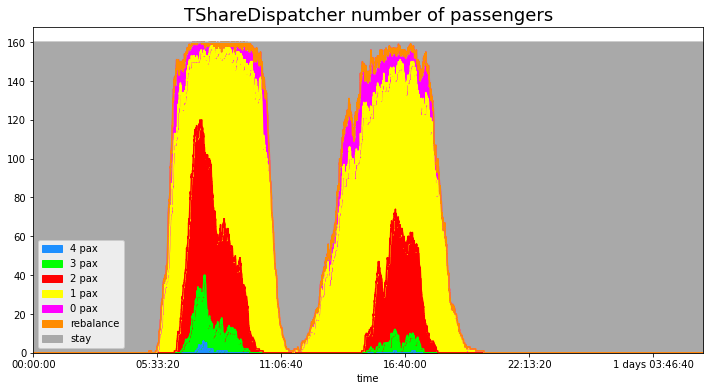

<Figure size 432x288 with 0 Axes>

In [5]:
def get_occupancy_graphs(alg_path):
    """ reads the occupanct info and return a stacked graph of the data"""
    cols = ['4 pax', '3 pax', '2 pax', '1 pax', '0 pax', 'rebalance', 'stay']
    alg = os.path.basename(alg_path)
    if DRT in alg_path:
        df = get_drt_occupancy_stats(alg_path)
    else:
        df = get_amod_occupancy_stats(alg_path)
    
    cols = [c for c in cols if c in df.columns]
    ax = df.plot.area(stacked=True, 
                      title=alg + " number of passengers",
                      color=[COL_TO_COLOR.get(col) for col in cols],
                      x="time", y=cols, figsize=(12,6))
    ax.title.set_size(18)
    return ax

axes = iterate_algorithms(12, get_occupancy_graphs)
fig = plt.figure()
map(fig.add_axes, axes)
fig

# Wait time utils

In [36]:
def _get_amod_wait_time_stats(alg_path):
    full_path = os.path.join(alg_path, "output","data","RequestTravelTimes")
    df = read_amod_csv(full_path)
    df["wait time"] = df["pickup time"] - df["submission time"]
    return {"mean wait": df.mean(axis=0)["wait time"], 
            "95p wait": df.quantile(.95)["wait time"],}

def _get_drt_wait_time_stats(alg_path):
    alg = os.path.basename(alg_path)
    full_path = os.path.join(alg_path, "output","drt_customer_stats_av.csv")
    df = pd.read_csv(full_path, sep=";")
    last_it = df.iloc[-1]
    return {"mean wait": last_it["wait_average"], 
            "95p wait": last_it["wait_p95"],}

def get_wait_stats(alg_path):
    """ returns mean and 95p for that algorithm"""
    if DRT in alg_path:
        result = _get_drt_wait_time_stats(alg_path)
    else:
        result = _get_amod_wait_time_stats(alg_path)
    return pd.Series(result)
    
r = iterate_algorithms(9, get_wait_stats)
pd.DataFrame(r).stack().unstack(level=-2)

output for RUN_ID: 9, from func: get_wait_stats


,mean wait,95p wait
DRT,597.540000,1279.90
DynamicRideSharingStrategy,315.806875,591.05
ExtDemandSupplyBeamSharing,287.869375,604.20
HighCapacityDispatcher,490.124375,1294.40
TShareDispatcher,275.153750,590.05


# Population Utils

person        int64
distance    float64
dtype: object


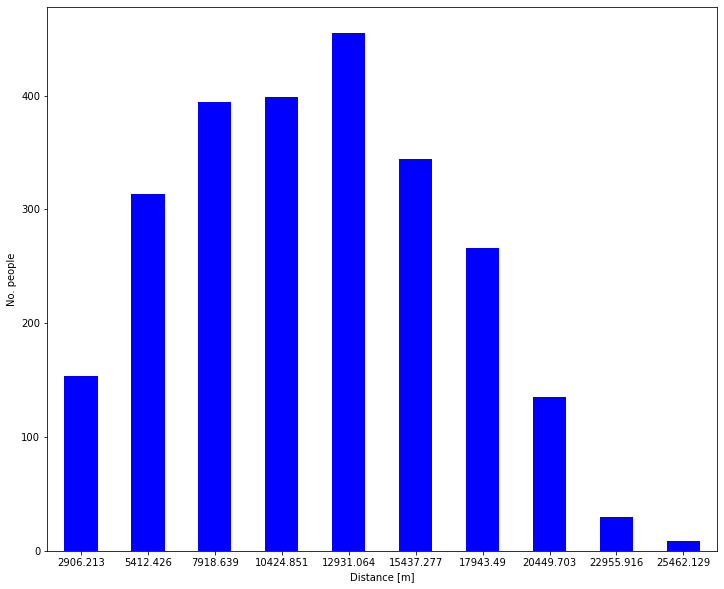

In [67]:
def get_origin_destination_data(alg_path):
    pop_filename = "Population*.xml.DistanceInfo.csv"
    path = glob.glob(os.path.join(alg_path, pop_filename))[0]
    df = pd.read_csv(path, names=["person", "distance"], skiprows=1)
    return pd.cut(df["distance"], include_lowest=True, bins=10)

out = get_origin_destination_data(r"E:\Files\CodeProjects\MATSim\Scenarios\runner-tests\9\DRT")
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,10))
ax.set_xticklabels([c.right for c in out.cat.categories])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("No. people")
plt.show()